# MNIST digit classifier (gradient histogram)

In [122]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mnist
import pickle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(12345)
EPS = 1e-8

In [2]:
def save_data(filename, data):
    with open("saved_data/{}.pickle".format(filename), mode='wb') as file:
        pickle.dump(data, file)

def load_data(filename):
    with open("saved_data/{}.pickle".format(filename), mode='rb') as file:
        data = pickle.load(file)
    return data

#### Preparing the data

In [3]:
mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

mnist_val_images = mnist.test_images().astype(np.float32) / 255.0
mnist_val_labels = mnist.test_labels()

In [4]:
TRAIN_SIZE = 60000  # out of 60000
VALID_SIZE = 10000  # out of 10000
DIGIT_DIM  = 28

In [62]:
X_train = mnist_train_images[:TRAIN_SIZE]
y_train = pd.Series(mnist_train_labels[:TRAIN_SIZE], name='Digit')

X_valid = mnist_val_images[:VALID_SIZE]
y_valid = pd.Series(mnist_val_labels[:VALID_SIZE], name='Digit')

#### Visualization of digits

In [6]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

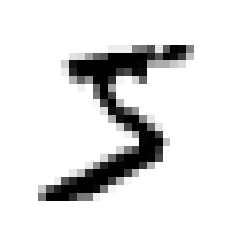

In [7]:
plot_digit(X_train[0])

#### Gradient histograms

In [155]:
def angle(c):
    return (2 * np.pi + np.angle(c)) % (2 * np.pi)

def length(c):
    return np.abs(c)

def get_gradient(window):
    sqrt2 = np.sqrt(2)
    mask = np.array([
        [np.complex(-1,  1)/sqrt2,  np.complex(0,  1),  np.complex(1,  1)/sqrt2],
        [np.complex(-1,  0),        np.complex(0,  0),  np.complex(1,  0)      ],
        [np.complex(-1, -1)/sqrt2,  np.complex(0, -1),  np.complex(1, -1)/sqrt2]
    ])
    return np.sum((window - window[1, 1]) * mask, keepdims=False)

def classify(angle):
    for i, threshold in enumerate(np.arange(0., 2*np.pi-EPS, np.pi/4.)[1:]):
        if angle < threshold: return i
    return 7

def get_gradient_histogram(image):
    bins = np.zeros(8)
    for i in range(image.shape[0]-2):
        for j in range(image.shape[1]-2):
            gradient = get_gradient(image[i:i+3, j:j+3])
            bins[classify(angle(gradient))] += length(gradient)
    return bins / np.sum(bins)

In [9]:
def get_preprocessed_data(data, verbose=False, log_every_n=100):
    results = []
    for i, image in enumerate(data):
        results += [get_gradient_histogram(image)]
        if verbose and (i+1) % log_every_n == 0:
            print("{} entries preprocessed".format(i+1))
    return pd.DataFrame(
        data = results,
        columns = ["[0-45)", "[45-90)", "[90-135)", "[135-180)",
                   "[180-225)", "[225-270)", "[270-315)", "[315-360)"]
    )

In [10]:
# Already done.
# There is no need to recompute those lines unless the pickled data is not available.
# May take a while (about 10-15 minutes) to complete.

#X_train_prep = get_preprocessed_data(X_train, verbose=True)
#X_valid_prep = get_preprocessed_data(X_valid, verbose=True)
#
#save_data("preprocessed_train", X_train_prep)
#save_data("preprocessed_valid", X_valid_prep)

In [11]:
X_train_prep = load_data("preprocessed_train")
X_valid_prep = load_data("preprocessed_valid")

#### Data representation

In [70]:
pd.concat([X_train_prep, y_train], axis=1)

,[0-45),[45-90),[90-135),[135-180),[180-225),[225-270),[270-315),[315-360),Digit
0,0.091484,0.121520,0.229507,0.073566,0.054029,0.092758,0.302438,0.034699,5
1,0.102157,0.058565,0.178407,0.141014,0.130560,0.046953,0.156351,0.185992,0
2,0.122076,0.057041,0.119751,0.203791,0.131463,0.039369,0.118820,0.207689,4
3,0.029581,0.041085,0.040922,0.387995,0.030209,0.025472,0.047982,0.396754,1
4,0.145570,0.060391,0.126131,0.186650,0.120821,0.064979,0.172985,0.122474,9
...,...,...,...,...,...,...,...,...,...
59995,0.119350,0.053528,0.225331,0.120854,0.085575,0.074577,0.200466,0.120319,8
59996,0.072841,0.215316,0.109858,0.085391,0.124911,0.116391,0.179717,0.095577,3
59997,0.090702,0.133676,0.194997,0.096673,0.080068,0.107982,0.239370,0.056530,5
59998,0.033292,0.047038,0.226472,0.187898,0.028034,0.066507,0.187688,0.223072,6


In [71]:
pd.concat([X_valid_prep, y_valid], axis=1)

,[0-45),[45-90),[90-135),[135-180),[180-225),[225-270),[270-315),[315-360),Digit
0,0.040419,0.108483,0.096786,0.258077,0.026351,0.118875,0.097470,0.253538,7
1,0.051598,0.094643,0.195062,0.168069,0.048596,0.101454,0.151877,0.188700,2
2,0.013501,0.024924,0.029489,0.409459,0.046805,0.010333,0.023506,0.441983,1
3,0.093044,0.068996,0.172446,0.114002,0.156119,0.059644,0.137867,0.197881,0
4,0.110911,0.060810,0.069231,0.270987,0.109173,0.033638,0.068791,0.276458,4
...,...,...,...,...,...,...,...,...,...
9995,0.044873,0.096152,0.240785,0.091689,0.087781,0.092716,0.150265,0.195740,2
9996,0.113062,0.148025,0.158665,0.066790,0.155716,0.119345,0.161414,0.076983,3
9997,0.068158,0.066896,0.066237,0.312737,0.060549,0.042967,0.061717,0.320739,4
9998,0.073185,0.131448,0.204724,0.079694,0.087894,0.120674,0.173511,0.128871,5


In [67]:
averages = pd.concat([X_train_prep, y_train], axis=1).groupby(['Digit']).mean()
averages

,[0-45),[45-90),[90-135),[135-180),[180-225),[225-270),[270-315),[315-360)
Digit,,,,,,,,
0,0.105788,0.078778,0.153022,0.158236,0.111814,0.079555,0.136893,0.175913
1,0.141125,0.029617,0.046503,0.279922,0.146603,0.027471,0.034884,0.293874
2,0.077360,0.114690,0.191227,0.108158,0.091999,0.111455,0.174619,0.130493
3,0.077591,0.138780,0.180163,0.099061,0.093214,0.114464,0.197313,0.099414
4,0.098193,0.074240,0.099690,0.220578,0.112741,0.066065,0.090608,0.237883
5,0.076191,0.124163,0.210392,0.082749,0.080798,0.138833,0.180040,0.106833
6,0.083518,0.074056,0.149120,0.190791,0.086689,0.079693,0.127544,0.208589
7,0.072480,0.079345,0.123311,0.228308,0.058715,0.081533,0.138287,0.218020
8,0.115095,0.086035,0.155353,0.145035,0.111634,0.088025,0.149750,0.149072


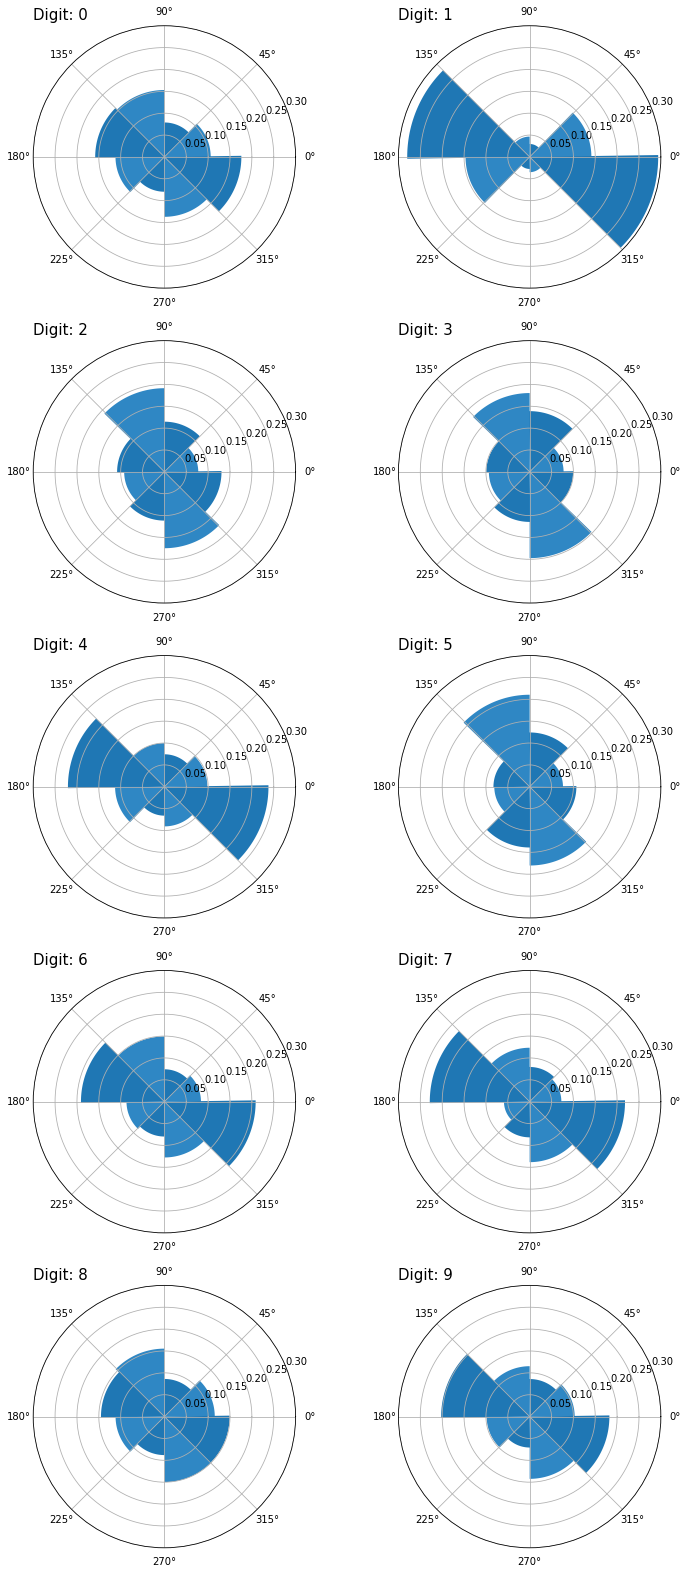

In [88]:
fig = plt.figure(figsize=(12, 28))
theta = np.linspace(0, 2*np.pi, 8, endpoint=False)

for i in range(10):
    plt.subplot(5, 2, i+1, projection='polar')
    plt.title("Digit: {}".format(i), loc='left', fontsize=15)
    bars = plt.bar(theta, averages.loc[i], align='edge')
    plt.yticks(np.arange(0.05, 0.31, 0.05))
    plt.ylim(0., 0.3)

    for i, bar in enumerate(bars):
        if i & 1: bar.set_fc("#1f77b4")
        else:     bar.set_fc("#2f87c4")

plt.show()

#### Model: KNN

In [136]:
knn_pipe = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('model', KNeighborsClassifier(n_neighbors=25))
])

In [137]:
knn_pipe.fit(X_train_prep, y_train)

Pipeline(memory=None,
         steps=[('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=25, p=2,
                                      weights='uniform'))],
         verbose=False)

In [138]:
predictions = knn_pipe.predict(X_valid_prep)

In [139]:
accuracy = accuracy_score(predictions, y_valid[:VALID_SIZE])
print("Accuracy: {:.2f}%".format(100*accuracy))

Accuracy: 52.36%


#### Model: Random Forest

In [110]:
forest_classif = RandomForestClassifier(n_estimators=160, random_state=1)

In [111]:
forest_classif.fit(X_train_prep, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=160,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [112]:
predictions = forest_classif.predict(X_valid_prep)

In [113]:
accuracy = accuracy_score(predictions, y_valid[:VALID_SIZE])
print("Accuracy: {:.2f}%".format(100*accuracy))

Accuracy: 53.44%


Both results are pretty bad. They are better than guessing but their performance is unsatisfactory to say the least.

#### Can we do better?

Proposition: smaller bins.

In [176]:
def classify_(angle):
    for i, threshold in enumerate(np.arange(0., 2*np.pi-EPS, np.pi/6.)[1:]):
        if angle < threshold: return i
    return 11

def get_gradient_histogram_(image):
    bins = np.zeros(12)
    for i in range(image.shape[0]-2):
        for j in range(image.shape[1]-2):
            gradient = get_gradient(image[i:i+3, j:j+3])
            bins[classify_(angle(gradient))] += length(gradient)
    return bins / np.sum(bins)

def get_preprocessed_data_(data, verbose=False, log_every_n=100):
    results = []
    for i, image in enumerate(data):
        results += [get_gradient_histogram_(image)]
        if verbose and (i+1) % log_every_n == 0:
            print("{} entries preprocessed".format(i+1))
    return pd.DataFrame(
        data = results,
        columns = ["[0-30)", "[30-60)", "[60-90)", "[90-120)", "[120-150]", "[150-180]",
                   "[180-210)", "[210-240)", "[240-270)", "[270-300)", "[300-330]", "[330-360]"]
    )

In [178]:
# Already done.
# There is no need to recompute those lines unless the pickled data is not available.
# May take a while (about 10-15 minutes) to complete.

#X_train_prep_2 = get_preprocessed_data_(X_train, verbose=True)
#X_valid_prep_2 = get_preprocessed_data_(X_valid, verbose=True)
#
#save_data("preprocessed_train_2", X_train_prep_2)
#save_data("preprocessed_valid_2", X_valid_prep_2)

In [179]:
X_train_prep_2 = load_data("preprocessed_train_2")
X_valid_prep_2 = load_data("preprocessed_valid_2")

In [186]:
pd.concat([X_train_prep_2, y_train], axis=1)

,[0-30),[30-60),[60-90),[90-120),[120-150],[150-180],[180-210),[210-240),[240-270),[270-300),[300-330],[330-360],Digit
0,0.036657,0.099441,0.076905,0.170582,0.092802,0.039689,0.034286,0.076470,0.036031,0.265741,0.055450,0.015946,5
1,0.090186,0.024286,0.046250,0.099293,0.148672,0.071456,0.100624,0.053655,0.023235,0.086913,0.159518,0.095912,0
2,0.105526,0.033345,0.040245,0.116039,0.011866,0.195637,0.113595,0.027748,0.029490,0.098441,0.061001,0.167067,4
3,0.020538,0.023382,0.026746,0.007531,0.193896,0.227490,0.030209,0.016193,0.009279,0.020107,0.201047,0.223582,1
4,0.121645,0.053046,0.031270,0.073998,0.126814,0.111968,0.094331,0.039843,0.051626,0.104531,0.120095,0.070833,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.093448,0.039336,0.040095,0.098072,0.176180,0.071933,0.066149,0.048676,0.045327,0.098861,0.154283,0.067641,8
59996,0.055200,0.056651,0.176306,0.072345,0.063525,0.059378,0.089464,0.060788,0.091049,0.133764,0.098644,0.042886,3
59997,0.065247,0.056564,0.102567,0.159703,0.058205,0.073762,0.065054,0.045042,0.077954,0.209526,0.056550,0.029824,5
59998,0.026553,0.023743,0.030034,0.122876,0.197123,0.094370,0.023628,0.031506,0.039406,0.120199,0.187566,0.102995,6


In [187]:
pd.concat([X_valid_prep_2, y_valid], axis=1)

,[0-30),[30-60),[60-90),[90-120),[120-150],[150-180],[180-210),[210-240),[240-270),[270-300),[300-330],[330-360],Digit
0,0.022766,0.029061,0.097075,0.078120,0.090346,0.186397,0.017358,0.013090,0.114779,0.085272,0.118230,0.147506,7
1,0.041889,0.027352,0.077120,0.165262,0.093532,0.104338,0.026137,0.035216,0.088698,0.135693,0.097441,0.107324,2
2,0.013179,0.017243,0.008003,0.020783,0.044509,0.373655,0.035193,0.021945,0.000000,0.017011,0.041187,0.407291,1
3,0.067722,0.051273,0.043045,0.089947,0.125040,0.071461,0.108377,0.089431,0.017956,0.066078,0.143018,0.126651,0
4,0.095137,0.031831,0.044693,0.054900,0.046205,0.239174,0.095129,0.028615,0.019066,0.059404,0.065609,0.220236,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.035419,0.040808,0.064797,0.196902,0.083789,0.051783,0.066585,0.061947,0.051965,0.106821,0.185469,0.053715,2
9996,0.077174,0.111172,0.072741,0.129796,0.063109,0.032549,0.110267,0.101172,0.063623,0.124993,0.060538,0.052866,3
9997,0.042856,0.051955,0.040243,0.035942,0.082836,0.260196,0.051189,0.024434,0.027893,0.042273,0.160834,0.179348,4
9998,0.040192,0.065804,0.098638,0.148955,0.078647,0.056815,0.055360,0.055235,0.097973,0.145096,0.050258,0.107028,5


In [188]:
averages_2 = pd.concat([X_train_prep_2, y_train], axis=1).groupby(['Digit']).mean()
averages_2

,[0-30),[30-60),[60-90),[90-120),[120-150],[150-180],[180-210),[210-240),[240-270),[270-300),[300-330],[330-360]
Digit,,,,,,,,,,,,
0,0.079954,0.053714,0.050914,0.090413,0.121074,0.099756,0.083732,0.057440,0.050207,0.083739,0.124659,0.104396
1,0.128490,0.025350,0.016929,0.020992,0.084986,0.220423,0.132792,0.026505,0.014801,0.017028,0.088576,0.223127
2,0.052883,0.057325,0.081848,0.139272,0.091176,0.068939,0.063846,0.061347,0.078258,0.122570,0.110939,0.071596
3,0.048723,0.068394,0.099245,0.134181,0.082158,0.062899,0.063500,0.064192,0.079972,0.141876,0.101671,0.053187
4,0.077615,0.044542,0.050301,0.066145,0.090721,0.163386,0.091236,0.044272,0.043311,0.053876,0.115519,0.159076
5,0.051357,0.058079,0.090918,0.163613,0.078469,0.051066,0.052026,0.066849,0.100742,0.141313,0.082408,0.063162
6,0.062809,0.044486,0.050294,0.089188,0.132286,0.118419,0.061704,0.053382,0.051312,0.077675,0.133814,0.124632
7,0.053684,0.040204,0.057954,0.084573,0.114160,0.152875,0.046428,0.028545,0.065281,0.110249,0.103610,0.142436
8,0.082489,0.064250,0.054396,0.091205,0.120401,0.088783,0.080362,0.061813,0.057486,0.096085,0.112017,0.090712


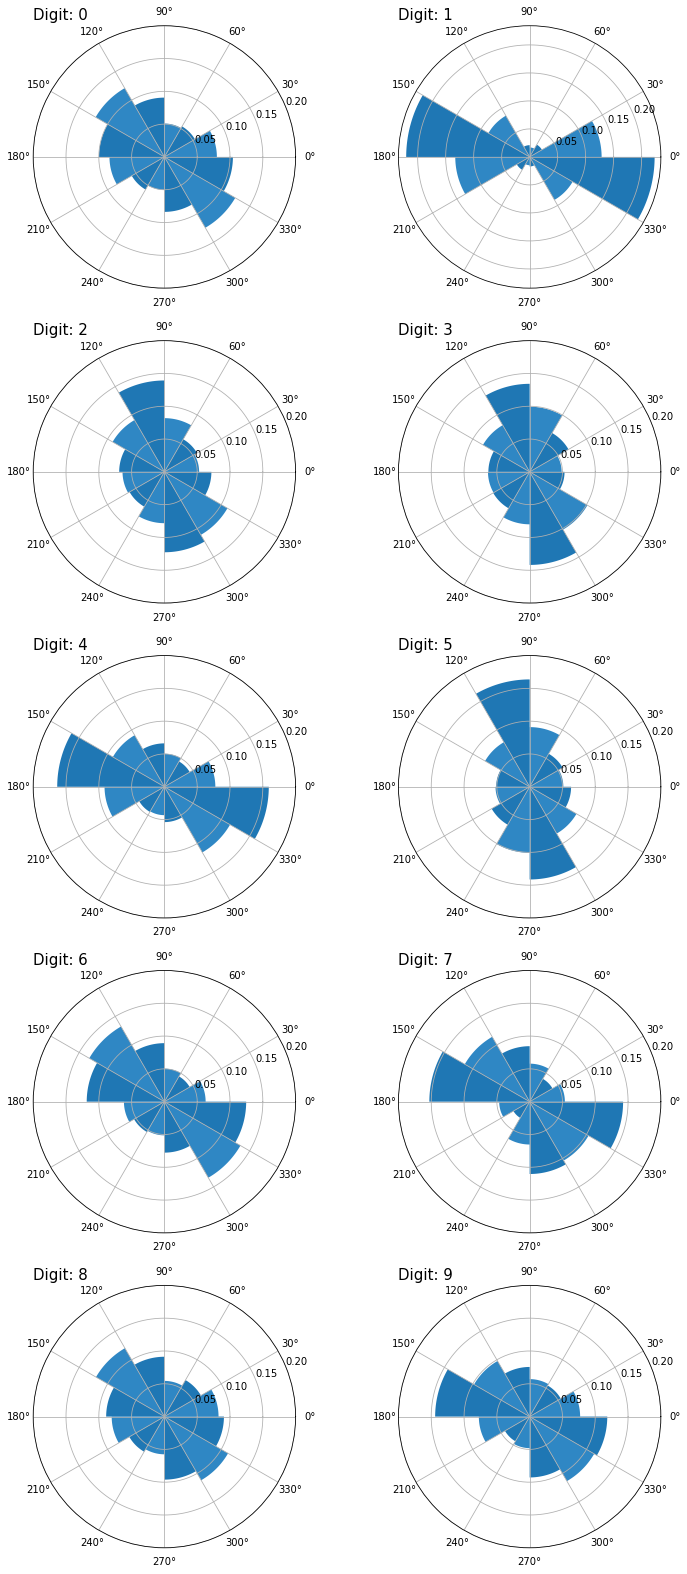

In [196]:
fig = plt.figure(figsize=(12, 28))
theta = np.linspace(0, 2*np.pi, 12, endpoint=False)

for i in range(10):
    plt.subplot(5, 2, i+1, projection='polar')
    plt.title("Digit: {}".format(i), loc='left', fontsize=15)
    bars = plt.bar(theta, averages_2.loc[i], align='edge', width=np.pi/6)
    plt.xticks(np.arange(0., 2*np.pi, np.pi/6))
    plt.yticks(np.arange(0.05, 0.21, 0.05))
    plt.ylim(0.)

    for i, bar in enumerate(bars):
        if i & 1: bar.set_fc("#1f77b4")
        else:     bar.set_fc("#2f87c4")

plt.show()

In [185]:
knn_pipe = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('model', KNeighborsClassifier(n_neighbors=50))
])

knn_pipe.fit(X_train_prep_2, y_train)
predictions = knn_pipe.predict(X_valid_prep_2)
accuracy = accuracy_score(predictions, y_valid[:VALID_SIZE])
print("Accuracy: {:.2f}%".format(100*accuracy))

Accuracy: 60.98%


In [181]:
forest_pipe = Pipeline(steps=[
    ('model', RandomForestClassifier(n_estimators=160, random_state=1))
])

forest_pipe.fit(X_train_prep_2, y_train)
predictions = forest_pipe.predict(X_valid_prep_2)
accuracy = accuracy_score(predictions, y_valid[:VALID_SIZE])
print("Accuracy: {:.2f}%".format(100*accuracy))

Accuracy: 63.60%


Using 12 bins didn't improve the classification rates significantly.